#Imports
Everyting with torch is for PyTorch which is our system for the neural network

Numpy, pandas, and matlab is for structuring and visualisation of data
%matplotlib and %config is used to show graphs in line in the google collab view

In [0]:
# imports related to PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict

# python tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# other
import json
from PIL import Image

# google collab specific
from google.colab import drive

#Loading of data
We are using `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, there has been applyed transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three set we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

#### Gets acces to the google drive folder
\* only run if using google collab

In [8]:
# gets acces to the google drive folder
drive.mount('/content/gdrive')
%cd "gdrive/My Drive/cs3_Rasmussen/Collab/_DATA/GreenMinds-data-5"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/cs3_Rasmussen/Collab/_DATA/GreenMinds-data-5


#### getting the data
we are using the data loader class from PyTorch which means that the images should be arranged following this structure:

* class 'dog'
    * root/dog/xxx.png
    * root/dog/xxy.png
    * root/dog/xxz.png
* class 'cat'
    * root/cat/123.png
    * root/cat/nsdf3.png
    * root/cat/asd932_.png



In [0]:
# paths to data needs to get changed, for new data location, for google collab use box above
path = ''

data_dir = {
    'train': path + 'train',
    'valid': path+ 'valid',
    'test': path + 'test'   
}

# Defines the transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
                transforms.RandomRotation(30),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
    'valid': transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ]),
    'test': transforms.Compose([
                transforms.Resize(255),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
}

# Loads the datasets with ImageFolder
data_datasets = {
    'train': datasets.ImageFolder(data_dir['train'], transform=data_transforms['train']),
    'valid': datasets.ImageFolder(data_dir['valid'], transform=data_transforms['valid'])
    #'test': datasets.ImageFolder(data_dir['test'], transform=data_transforms['test'])
}

# Using the image datasets and the trainforms, defines the dataloaders
# we are using batch_size of 32 to make sure not to run out of memory on google collab
data_dataloaders = {
    'train': torch.utils.data.DataLoader(data_datasets['train'], batch_size=32, shuffle=True),
    'valid': torch.utils.data.DataLoader(data_datasets['valid'], batch_size=32)
    #'test': torch.utils.data.DataLoader(data_datasets['test'], batch_size=32)
}

# Building the classifier

Getting our pretrained model

In [14]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


Saves our classs names to their model index for use later in inferince

In [15]:
model.class_to_idx = data_datasets['train'].class_to_idx
model.class_to_idx

{'bear-top': 0,
 'box-takeout': 1,
 'box-white': 2,
 'carton-chicken': 3,
 'carton-grassmilk': 4,
 'carton-milk': 5,
 'comp-bread': 6,
 'comp-burger': 7,
 'comp-butter': 8,
 'comp-chicken': 9,
 'comp-fish': 10,
 'comp-watermelon': 11,
 'corner-cafe': 12,
 'croix-lemon': 13,
 'cup-starbucks': 14,
 'forest-bluff': 15,
 'frenchs-mustard': 16,
 'nestle-cookie': 17,
 'pnc-letter': 18,
 'starbucks-holder': 19,
 'usps-gray': 20}

Freezing the parameters so we wont backprop through them

In [0]:
for param in model.parameters():
    param.requires_gradu = False

Creating a new classifier for transfor learning

In [0]:
prediction_size = len(model.class_to_idx)

classifier = nn.Sequential(OrderedDict([
    ('fc_1', nn.Linear(1024, 512)),
    ('relu_1', nn.ReLU()),
    ('dropout_1', nn.Dropout(.2)),
    ('fc_2', nn.Linear(512, 256)),
    ('relu_2', nn.ReLU()),
    ('dropout_2', nn.Dropout(.2)),
    ('fc_3', nn.Linear(256, prediction_size)),
    ('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

Checks if cuda is enabled, and sends our model to the gpu if avaliable

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Defining hyper parameters

In [0]:
#@title Hyper parameters 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.1)

epochs =  2#@param {type:"integer"}
steps = 0
print_every_step =  20#@param {type:"integer"}

auto_save = True #@param {type:"boolean"}
save_path = 'checkpoint_2.pth' #@param {type:"string"}

Creating our training loop

In [0]:
# sets our model to train mode
model.train()
# sends our model to the device (cpu/gpu)
model = model.to(device)

# records the best accuracy to auto save best model
#best_accuracy = 0

# for graphing
#train_losses, test_losses = [], []

# runs through set amount of epochs
for epoch in range(epochs + 2):
    # holds our runnning loss
    running_loss = 0

    # loops over our train data
    for inputs, labels in data_dataloaders['train']:
        # add 1 to the number of steps done
        steps += 1
        
        # moves input- and labels- tensors to the device (cpu/gpu)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # resets our optimizer
        optimizer.zero_grad()
        # gets our log probabilities from our model
        logps = model.forward(inputs)
        # calculates the loss using our criterion
        loss = criterion(logps, labels)
        # backprobagates to update our weights
        loss.backward()
        optimizer.step()
        
        # adds our loss to the total loss, between validation
        running_loss += loss.item()
        
        # calculates our models current accuracy each x steps
        if steps % print_every_step == 0:
            # holds our test loss
            test_loss = 0
            # holds our total accuracy
            accuracy = 0
            
            # sets our model to eval, to stop dropout
            model.eval()
            
            # stops our optimizer for better performance
            with torch.no_grad():
                # loops through our validation data
                for inputs, labels in data_dataloaders['valid']:
                    # moves input- and labels- tensors to the device (cpu/gpu)
                    inputs, labels = inputs.to(device), labels.to(device)
                    
                    # gets our log probabilities from our model
                    logps = model.forward(inputs)
                    # calculates the loss using our criterion
                    batch_loss = criterion(logps, labels)
                    # adds our loss to the total loss validation loss
                    test_loss += batch_loss.item()
                    
                    # ---Calcualtes the accuracy
                    # converts to probabilities
                    ps = torch.exp(logps)
                    # gets the top prediction
                    top_p, top_class = ps.topk(1, dim=1)
                    # Check if it is equal to the label
                    equals = top_class == labels.view(*top_class.shape)
                    # adds our accuracy this step to the total validation accuracy
                    accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            train_losses.append(running_loss/print_every_step)
            test_losses.append(test_loss/len(data_dataloaders['valid']))
            
            # Prints out data about our current model accuracy and losses
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every_step:.3f}.. "
                  f"Test loss: {test_loss/len(data_dataloaders['valid']):.3f}.. "
                  f"Test accuracy: {accuracy/len(data_dataloaders['valid']):.10f}")
            
            # saves the model if it has improved and auto save is on
            if ((accuracy/len(data_dataloaders['valid'])) >= best_accuracy) and auto_save:
                best_accuracy = accuracy/len(data_dataloaders['valid'])
                save_model_full(model, model.class_to_idx, save_path)
                print(f"Model with accuracy of {accuracy/len(data_dataloaders['valid']):.3f} saved")

            # resets our running loss
            running_loss = 0
            # resets our model to train mode
            model.train()

Epoch 1/2.. Train loss: 0.435.. Test loss: 0.828.. Test accuracy: 0.9270833135
Epoch 1/2.. Train loss: 1.411.. Test loss: 0.805.. Test accuracy: 0.9128788114
Epoch 1/2.. Train loss: 1.339.. Test loss: 0.923.. Test accuracy: 0.8636363745
Epoch 1/2.. Train loss: 1.476.. Test loss: 0.936.. Test accuracy: 0.7982954383
Epoch 1/2.. Train loss: 1.440.. Test loss: 0.906.. Test accuracy: 0.8816288114
Epoch 1/2.. Train loss: 1.308.. Test loss: 0.821.. Test accuracy: 0.8465909362
Epoch 1/2.. Train loss: 1.341.. Test loss: 0.826.. Test accuracy: 0.9261363745
Epoch 1/2.. Train loss: 1.404.. Test loss: 0.922.. Test accuracy: 0.8245920539
Epoch 1/2.. Train loss: 1.333.. Test loss: 0.759.. Test accuracy: 0.9469696879
Model with accuracy of 0.947 saved
Epoch 1/2.. Train loss: 1.404.. Test loss: 0.871.. Test accuracy: 0.8674242496
Epoch 1/2.. Train loss: 1.381.. Test loss: 0.934.. Test accuracy: 0.7897727489
Epoch 1/2.. Train loss: 1.346.. Test loss: 0.879.. Test accuracy: 0.8465909362
Epoch 1/2.. Train

#### Plots training vs validation loss
used to check for over / under fitting

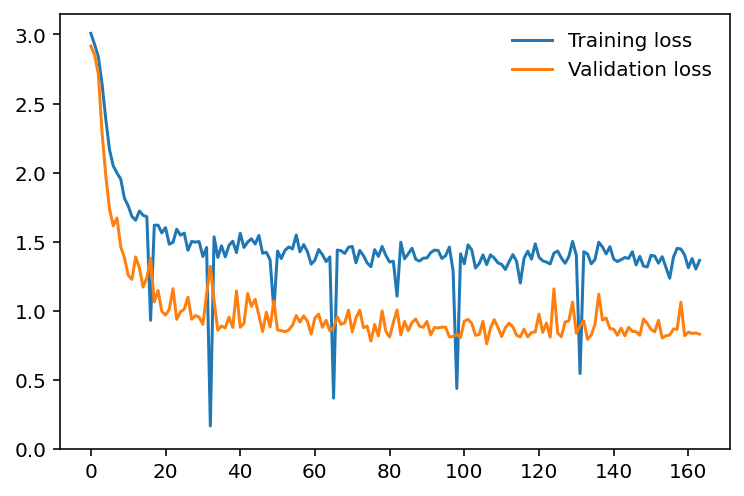

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.ylim(bottom=0)
plt.legend(frameon=False)

# Validation on the test set

In [0]:
# holds our total test loss
test_loss = 0
# holds our total accuracy
accuracy = 0
# sends our model to the device (cpu/gpu)
model = model.to(device)
# sets our model to eval mode
model.eval()

# stops our optimizer for better performance
with torch.no_grad():
    # loops over our test data
    for inputs, labels in data_dataloaders['test']:
        # moves input- and labels- tensors to the device (cpu/gpu)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # gets our log probabilities from our model
        logps = model.forward(inputs)
        
        # --- Calcualtes the accuracy
        # converts to probabilities
        ps = torch.exp(logps)
        # gets the top prediction
        top_p, top_class = ps.topk(1, dim = 1)
        # Check if it is equal to the label
        equals = top_class == labels.view(*top_class.shape)
        # adds our accuracy this step to the total test accuracy
        accuracy += torch.mean(equals.type(torch.FloatTensor))

# prints out the final result
print('Test accuracy: {}'.format(accuracy / len(data_dataloaders['test'])))

# Saving / loading the model

In [0]:
def save_model(model, epoch, class_to_idx, path):
    '''
        saves model state dict for loading later, 
        to load this saved model is an internet connecting recuired to load a densenet model
    '''

    torch.save({
        'model_state_dict' : model.state_dict(),
        'epochs' : epoch,
        'class_to_idx' : class_to_idx
    }, path)

def save_model_full(model, class_to_idx, path):
    '''
        Saves a full model so it can be loaded without an internet connection
    '''
    torch.save({
            'model': model,
            'class_to_idx': class_to_idx
            }, path)


#save_model(model, 2, model.class_to_idx, '/content/gdrive/My Drive/cs3_Rasmussen/Collab/_DATA/GreenMinds-recycling-data/densenet_checkpoint.pth')
#save_model_full(model, model.class_to_idx, '/content/gdrive/My Drive/cs3_Rasmussen/Collab/_DATA/GreenMinds-recycling-data/densenet_checkpoint_full.pth')

In [0]:
def load_model(path):
    '''
        loads a preetrained model of type densenet121
        an internet connection is required to load the densenet model
    '''
    # loads the data
    checkpoint = torch.load(path)

    # downloads the pre trained model
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_gradu = False

    # re-creates the classifier
    prediction_size = len(checkpoint['class_to_idx'])
    classifier = nn.Sequential(OrderedDict([
        ('fc_1', nn.Linear(1024, 512)),
        ('relu_1', nn.ReLU()),
        ('dropout_1', nn.Dropout(.2)),
        ('fc_2', nn.Linear(512, 256)),
        ('relu_2', nn.ReLU()),
        ('dropout_2', nn.Dropout(.2)),
        ('fc_3', nn.Linear(256, prediction_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    model.classifier = classifier

    # loads the old weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # stores the class_to_idx
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

def load_model_full(path):
    '''
        loads a model and its custom class_to_idx var, without internet requirement
    '''
    # loads the data
    checkpoint = torch.load(path)

    model = checkpoint['model']
    model.class_to_idx = checkpoint['class_to_idx']

    return model


#model = load_model('/content/gdrive/My Drive/cs3_Rasmussen/Collab/_DATA/GreenMinds-recycling-data/densenet_checkpoint.pth')
model = load_model_full('checkpoint_2.pth')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Sanity check

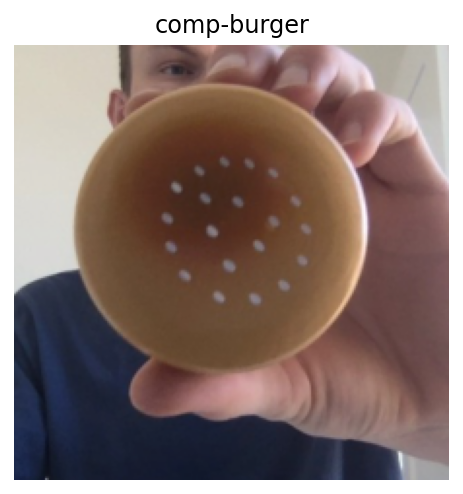

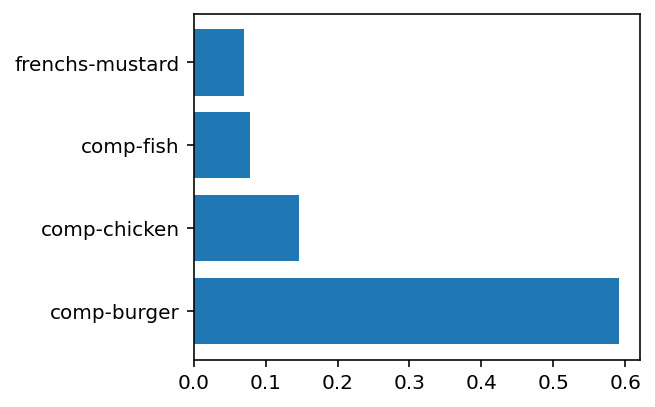

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # creates the pre proccessing transforms
    resize = transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
    # applying transforms and returns the image
    return resize(image)

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

def predict(image_path, model, device, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # opens the image and applies preproccessing
    image = process_image(Image.open(image_path))
    # unsqueezes it
    image = image.unsqueeze_(0)
    # sends it to our device (cpu/gpu)
    image = image.to(device)
    model = model.to(device)
    
    # sets our model to eval mode, to disable dropout
    model.eval()
    # stops our optimizer for better performance
    with torch.no_grad():
        # gets our log probabilities from our model
        logps = model.forward(image)

    # converts to probabilities
    ps = torch.exp(logps)
    
    # Get the top 5 probabilities and classes
    prop, classes = ps.topk(topk, dim=1)

    # Get the first items in the tensor list which contains the probs and classes
    top_p = prop.tolist()[0]
    top_classes = classes.tolist()[0]

    # sets up a lost to hold our labels
    labels = []

    # reverses our class_to_idx which our model holds
    idx_to_class = {v : k for k, v in model.class_to_idx.items()}

    # loops through each prediction to find the labels instead of numbers
    for c in top_classes:
        # adds the name which our model did predict
        labels.append(idx_to_class[c])

    # returns our top k probabilities and labels as lists.
    return top_p, labels

def sanity_check(test_image_path, test_image_title, model, device):
    '''
        Prints image to test, and resoults from model
    '''
    # opens the image and applies preproccessing
    proccessed_image = process_image(Image.open(test_image_path))
    # displays the image with the correct label
    ax = imshow(proccessed_image, title=test_image_title)

    # Gets our top  image prediction from our model
    probs, classes = predict(test_image_path, model, device, 4)

    # creates a new fig
    fig = plt.figure(figsize=(4, 7))
    # adds a subplot for our graph
    ax2 = fig.add_subplot(2, 1 , 2)
    # creates the graph
    ax2.barh(classes, probs)

#@title Sanity check image { display-mode: "form" }
data_path = 'valid' #@param {type:"string"}
g_class = 'comp-burger' #@param {type:"string"}

sanity_check(data_path + "/" + g_class + '/image_0.jpg', g_class, model, device)